In [67]:
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)

import os
import wget
from pathlib import Path
from torch.nn.utils import clip_grad_norm_
from matplotlib import pyplot as plt
%matplotlib inline

In [68]:

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [69]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


In [70]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


In [71]:

unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [72]:
input_dim = X_train.shape[1]
from utils_output import infer_output_dim
output_dim, train_labels = infer_output_dim(y_train)
classes_ = train_labels
target_mapper = {
    class_label: index for index, class_label in enumerate(classes_)
}
preds_mapper = {
    str(index): class_label for index, class_label in enumerate(classes_)
}


In [73]:
from typing import List, Any, Dict
n_d: int = 8
n_a: int = 8
n_steps: int = 3
gamma: float = 1.3
cat_idxs: List[int] =cat_idxs
cat_dims: List[int] = cat_dims
cat_emb_dim: int = 1
n_independent: int = 2
n_shared: int = 2
epsilon: float = 1e-15
momentum: float = 0.02
lambda_sparse: float = 1e-3
seed: int = 0
clip_value: int = 1
verbose: int = 1
optimizer_fn: Any = torch.optim.Adam
optimizer_params: Dict = dict(lr=2e-2)
scheduler_fn: Any = None
scheduler_params: Dict = {"step_size":50,"gamma":0.9}
mask_type: str = "sparsemax"
input_dim: int = input_dim
output_dim: int = output_dim
device_name: str = "auto"
device = torch.device("cpu")

In [74]:
import tab_network
pretraining_ratio = 0.5
virtual_batch_size = 128
network = tab_network.TabNetPretraining(
            input_dim,
            pretraining_ratio=pretraining_ratio,
            n_d=n_d,
            n_a=n_a,
            n_steps=n_steps,
            gamma=gamma,
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            cat_emb_dim=cat_emb_dim,
            n_independent=n_independent,
            n_shared=n_shared,
            epsilon=epsilon,
            virtual_batch_size=virtual_batch_size,
            momentum=momentum,
            mask_type=mask_type).to(device)

In [75]:
optim= optimizer_fn(network.parameters(),**optimizer_params)

In [76]:
from utils_dataset import create_explain_matrix

reducing_matrix = create_explain_matrix(
            network.input_dim,
            network.cat_emb_dim,
            network.cat_idxs,
            network.post_embed_dim,
        )


In [77]:
from utils_metric import UnsupervisedLoss
loss_fn = UnsupervisedLoss

In [78]:
 from torch.utils.data import DataLoader
batch_size= 32
sampler= None
need_shuffle= True
num_workers = 3
drop_last= True
pin_memory=True


In [79]:
train_dataloader = DataLoader(
        X_train.astype(np.float32),
        batch_size=batch_size,
        sampler=sampler,
        shuffle=need_shuffle,
        num_workers=num_workers,
        drop_last=drop_last,
        pin_memory=pin_memory,
    )

In [80]:
network.train()
X =next(iter(train_dataloader))
X = X.to(device).float()

for param in network.parameters():
    param.grad = None
output, embedded_x, obf_vars = network(X)
loss  = loss_fn(output, embedded_x, obf_vars)
loss.backward()
clip_value = 0.5
clip_grad_norm_(network.parameters(),clip_value)
optim.step()


In [81]:
network.train()
for batch_idx, X in enumerate(train_dataloader):
    X = X.to(device).float()
    for param in network.parameters():
        param.grad = None
    output, embedded_x, obf_vars = network(X)
    loss  = loss_fn(output, embedded_x, obf_vars)
    loss.backward()
    clip_value = 0.5
    clip_grad_norm_(network.parameters(),clip_value)
    optim.step()
    print(batch_idx , loss)


0 tensor(1.7173e+08, grad_fn=<MeanBackward0>)
1 tensor(19.8702, grad_fn=<MeanBackward0>)
2 tensor(4.8603, grad_fn=<MeanBackward0>)
3 tensor(19.5495, grad_fn=<MeanBackward0>)
4 tensor(94305240., grad_fn=<MeanBackward0>)
5 tensor(48872840., grad_fn=<MeanBackward0>)
6 tensor(13.6420, grad_fn=<MeanBackward0>)
7 tensor(25.3318, grad_fn=<MeanBackward0>)
8 tensor(4.6441, grad_fn=<MeanBackward0>)
9 tensor(5.0057, grad_fn=<MeanBackward0>)
10 tensor(5.5062, grad_fn=<MeanBackward0>)
11 tensor(9.5822, grad_fn=<MeanBackward0>)
12 tensor(5.5468, grad_fn=<MeanBackward0>)
13 tensor(5.2225, grad_fn=<MeanBackward0>)
14 tensor(2.7856, grad_fn=<MeanBackward0>)
15 tensor(15819585., grad_fn=<MeanBackward0>)
16 tensor(12228458., grad_fn=<MeanBackward0>)
17 tensor(2.6343, grad_fn=<MeanBackward0>)
18 tensor(2.3685, grad_fn=<MeanBackward0>)
19 tensor(16518528., grad_fn=<MeanBackward0>)
20 tensor(69.5757, grad_fn=<MeanBackward0>)
21 tensor(11018815., grad_fn=<MeanBackward0>)
22 tensor(9175754., grad_fn=<MeanBack

KeyboardInterrupt: 

In [ ]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape==embedded_X.shape)

In [85]:
from utils_dataset import TorchDataset , PredictDataset
network.eval()
dataloader = DataLoader(
    PredictDataset(X),
    batch_size=batch_size,
    shuffle=False,
)
results = []
embedded_res = []
for batch_nb, data in enumerate(dataloader):
    data = data.to(device).float()
    output, embeded_x, _ = network(data)
    predictions = output.cpu().detach().numpy()
    results.append(predictions)
    embedded_res.append(embeded_x.cpu().detach().numpy())
res_output = np.vstack(results)
embedded_inputs = np.vstack(embedded_res)

In [88]:
batch_size = 128
def explain( X):
    from scipy.sparse import csc_matrix
    """
    Return local explanation

    Parameters
    ----------
    X : tensor: `torch.Tensor`
        Input data

    Returns
    -------
    M_explain : matrix
        Importance per sample, per columns.
    masks : matrix
        Sparse matrix showing attention masks used by network.
    """
    network.eval()

    dataloader = DataLoader(
        PredictDataset(X),
        batch_size=batch_size,
        shuffle=False,
    )

    res_explain = []

    for batch_nb, data in enumerate(dataloader):
        data = data.to(device).float()

        M_explain, masks = network.forward_masks(data)
        for key, value in masks.items():
            masks[key] = csc_matrix.dot(
                value.cpu().detach().numpy(), reducing_matrix
            )

        res_explain.append(
            csc_matrix.dot(M_explain.cpu().detach().numpy(), reducing_matrix)
        )

        if batch_nb == 0:
            res_masks = masks
        else:
            for key, value in masks.items():
                res_masks[key] = np.vstack([res_masks[key], value])

    res_explain = np.vstack(res_explain)

    return res_explain, res_masks

In [89]:
import matplotlib.pyplot as plt
explain_matrix, masks = explain(X_test)

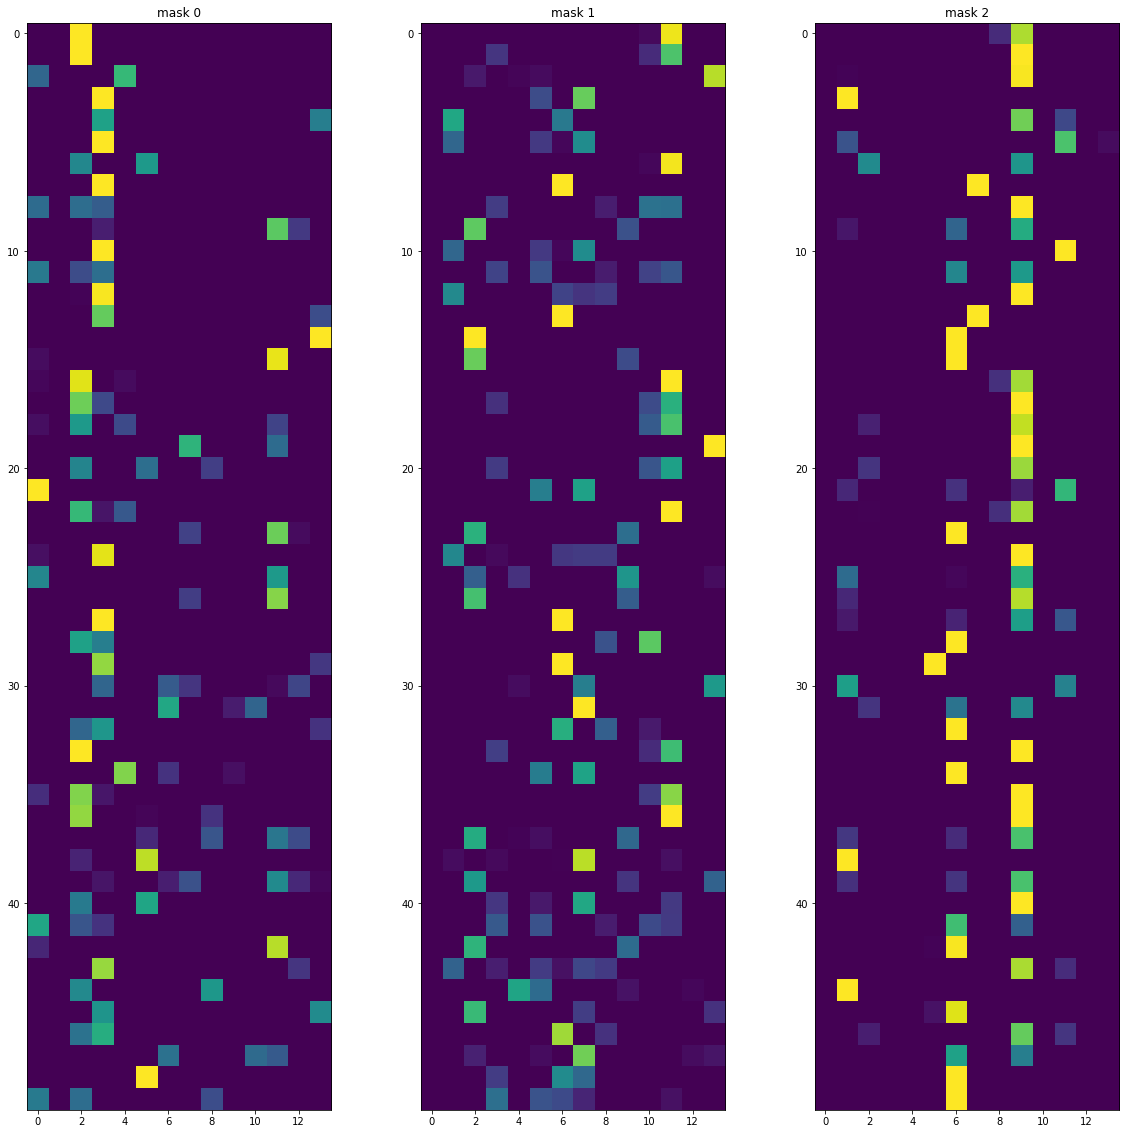

In [91]:

fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")